# IFF-AR pipeline 

This notebook performs an end-to-end pass on a single example of the validation: it loads the original audio, displays the spectrogram, generates the autoregressive prediction of the model, and compares the results.

## 1. Import and settings

In [1]:
from pathlib import Path
import json

import numpy as np
import torch
import matplotlib.pyplot as plt
import torchaudio
import torchaudio.functional as AF
from IPython.display import Audio
import sys

sys.path.append('src')
ROOT = Path.cwd()

from src.train import CONFIG, build_model, _device_and_scaler
from src.model.phase_rec import PhaseReconstructor

## 2. Loading configuration, statistics, and checkpoints
Retrieves training settings, normalisation statistics, and loads the pre-trained model.

In [2]:
CKPT_PATH = ROOT / "checkpoints/best.pt"
STATS_PATH = ROOT / Path(CONFIG['paths']['stats_path'])
MANIFEST_VAL = ROOT / Path(CONFIG['paths']['manifest_val'])
RAW_META_PATH = ROOT / MANIFEST_VAL.with_name('val.json')

stats = json.load(STATS_PATH.open())
mani_val = json.load(MANIFEST_VAL.open())
raw_val_meta = json.load(RAW_META_PATH.open())
id_to_raw = {entry['id']: entry['path'] for entry in raw_val_meta}

dev, _ = _device_and_scaler()
F_bins = int(mani_val['F'])
model = build_model(F_bins, dev)
ckpt = torch.load(CKPT_PATH, map_location=dev)
model.load_state_dict(ckpt['model_state_dict'])
model.eval()

recon = model.recon

L = CONFIG['data']['L']
K = CONFIG['data']['K']
target_sr = int(stats.get('meta', {}).get('sr', 16000))

## 3. Selecting a validation example
For simplicity, choose the entry with index 0 from the validation manifest; you can change `VAL_INDEX` to try other clips.

In [3]:
VAL_INDEX = 114

entry = mani_val['entries'][VAL_INDEX]
entry_id = entry['id']
print(f'Selected entry: {entry_id}')
raw_path = Path(id_to_raw.get(entry_id, id_to_raw.get(entry_id.split('_split')[0].split('.split')[0])))
raw_path = "" + str(raw_path)
print(f'Raw audio path: {raw_path}')

Selected entry: flute_synthetic_000-088-100
Raw audio path: dataset/nsynth-train/audio/flute_synthetic_000-088-100.wav


## 4. Original audio display
Load the sound wave and display the waveform and logarithmic spectrogram.

[UserWarning] torchaudio._backend.utils.load has been deprecated. This functionality has been superseded by `AudioDecoder` from the TorchCodec library. See https://github.com/pytorch/audio/issues/3902 for more details. It will be removed from the 2.9 release. 
Audio duration: 4.00 s, sample rate: 16000


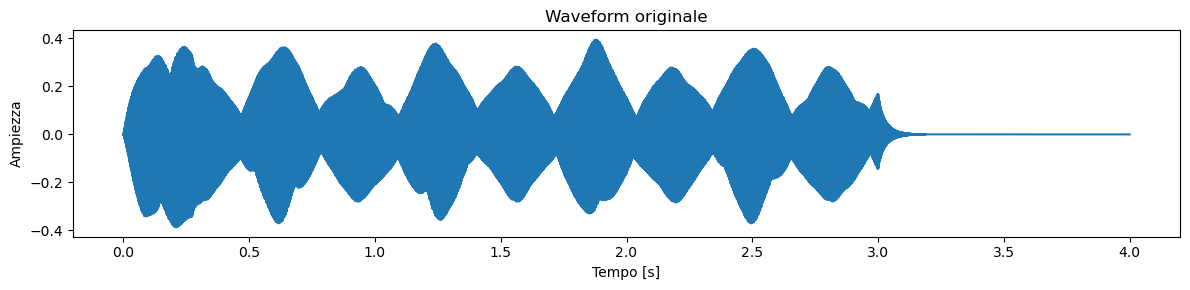

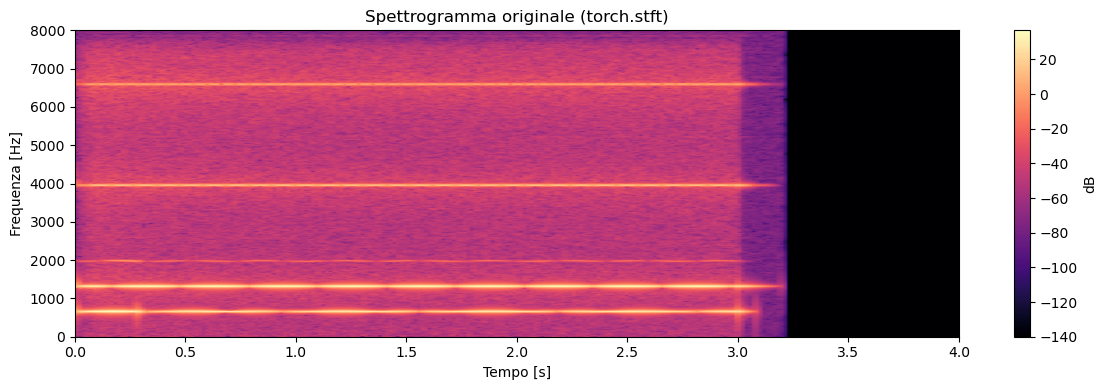

In [4]:
wav_ref_full, sr = torchaudio.load(str(raw_path))
if wav_ref_full.size(0) > 1:
    wav_ref_full = wav_ref_full.mean(dim=0, keepdim=True)
if sr != target_sr:
    wav_ref_full = AF.resample(wav_ref_full, sr, target_sr)
    sr = target_sr
y_ref_full = wav_ref_full.squeeze(0).cpu()

print(f'Audio duration: {y_ref_full.shape[0]/sr:.2f} s, sample rate: {sr}')

time_axis = torch.arange(y_ref_full.shape[0], dtype=torch.float32) / sr
plt.figure(figsize=(12, 3))
plt.plot(time_axis.numpy(), y_ref_full.numpy())
plt.title('Waveform originale')
plt.xlabel('Tempo [s]')
plt.ylabel('Ampiezza')
plt.tight_layout()
plt.show()

window = torch.hann_window(CONFIG['model']['win_length'])
spec = torch.stft(
    y_ref_full,
    n_fft=CONFIG['model']['n_fft'],
    hop_length=CONFIG['model']['hop'],
    win_length=CONFIG['model']['win_length'],
    window=window,
    center=True,
    return_complex=True,
)
spec_mag = spec.abs().clamp_min(1e-7)
spec_db = 20.0 * torch.log10(spec_mag)
spec_db_np = spec_db.cpu().numpy()

time_bins = np.arange(spec_db_np.shape[1]) * CONFIG['model']['hop'] / sr
freq_bins = np.linspace(0, sr / 2, spec_db_np.shape[0])

plt.figure(figsize=(12, 4))
plt.imshow(
    spec_db_np,
    origin='lower',
    aspect='auto',
    cmap='magma',
    extent=[time_bins[0], time_bins[-1], freq_bins[0], freq_bins[-1]],
)
plt.colorbar(label='dB')
plt.title('Spettrogramma originale (torch.stft)')
plt.xlabel('Tempo [s]')
plt.ylabel('Frequenza [Hz]')
plt.tight_layout()
plt.show()

## 5. Preparation of normalised features
Loads the normalised matrices produced by preprocessing and constructs the context and target tensor

In [5]:
def _resolve_entry_path(p):
    p = Path(p)
    if p.is_absolute():
        return p
    try:
        base = ROOT
    except NameError:
        base = Path.cwd().resolve()
    return (base / p)

M_path = _resolve_entry_path(entry['M_path'])
IF_path = _resolve_entry_path(entry['IF_path'])
PH_path = _resolve_entry_path(entry['PHI_path'])
phi0_path = _resolve_entry_path(entry['phi0_path'])

M_np = np.load(M_path).astype(np.float32)
IF_np = np.load(IF_path).astype(np.float32)
PH_np = np.load(PH_path).astype(np.float32)
phi0_np = np.load(phi0_path).astype(np.float32)

print('Feature shapes:', M_np.shape, IF_np.shape, PH_np.shape)
if M_np.shape[0] < L + K:
    raise ValueError('La clip selezionata è troppo corta per L+K frame')
start_idx = max(0, (M_np.shape[0] - (L + K)) // 2)
ctx_slice = slice(start_idx, start_idx + L)
tgt_slice = slice(start_idx + L, start_idx + L + K)

M_ctx_np = M_np[ctx_slice]
IF_ctx_np = IF_np[ctx_slice]
PH_ctx_np = PH_np[ctx_slice]
M_tgt_np = M_np[tgt_slice]
IF_tgt_np = IF_np[tgt_slice]

M_ctx = torch.from_numpy(M_ctx_np).unsqueeze(0).to(dev)
IF_ctx = torch.from_numpy(IF_ctx_np).unsqueeze(0).to(dev)
PH_ctx = torch.from_numpy(PH_ctx_np).unsqueeze(0).to(dev)
M_tgt = torch.from_numpy(M_tgt_np).unsqueeze(0).to(dev)
IF_tgt = torch.from_numpy(IF_tgt_np).unsqueeze(0).to(dev)

print('Context tensor shapes:', M_ctx.shape, IF_ctx.shape, PH_ctx.shape)

Feature shapes: (250, 513) (250, 513) (250, 513)
Context tensor shapes: torch.Size([1, 24, 513]) torch.Size([1, 24, 513]) torch.Size([1, 24, 513])


## 6. Autoregressive inference
Runs `forward_eval` to generate future frames and reconstructs both the prediction and reference for comparison.

In [6]:
with torch.no_grad():
    M_pred, IF_pred, phi0_chunk = model.forward_eval(M_ctx, IF_ctx, stats, K=K, L=L, phi_ctx=PH_ctx)
    if phi0_chunk is None:
        phi0_chunk = PH_ctx[:, -1]
    X_pred, phi_seq_pred, y_pred = recon.reconstruct_chunk(M_pred, IF_pred, stats, return_waveform=True, phi0=phi0_chunk)
    X_ref, _, y_ref = recon.reconstruct_chunk(M_tgt, IF_tgt, stats, return_waveform=True, phi0=phi0_chunk)

segment_samples = K * CONFIG['model']['hop']
segment_duration = segment_samples / target_sr
print(f'Segment length = {K} frame -> {segment_samples} sample -> {segment_duration:.3f} s')

M_pred_denorm = PhaseReconstructor.denorm_mag(M_pred.cpu(), stats)
M_ref_denorm = PhaseReconstructor.denorm_mag(M_tgt.cpu(), stats)
IF_pred_denorm = PhaseReconstructor.denorm_if(IF_pred.cpu(), stats)
IF_ref_denorm = PhaseReconstructor.denorm_if(IF_tgt.cpu(), stats)

y_pred_np = y_pred.squeeze(0).cpu().numpy()
y_ref_np = y_ref.squeeze(0).cpu().numpy()
print('Pred waveform samples:', y_pred_np.shape[0])
print('Ref waveform samples:', y_ref_np.shape[0])

Segment length = 8 frame -> 2048 sample -> 0.128 s
Pred waveform samples: 1792
Ref waveform samples: 1792


## 7. Spectrogram comparison (log-magnitude)

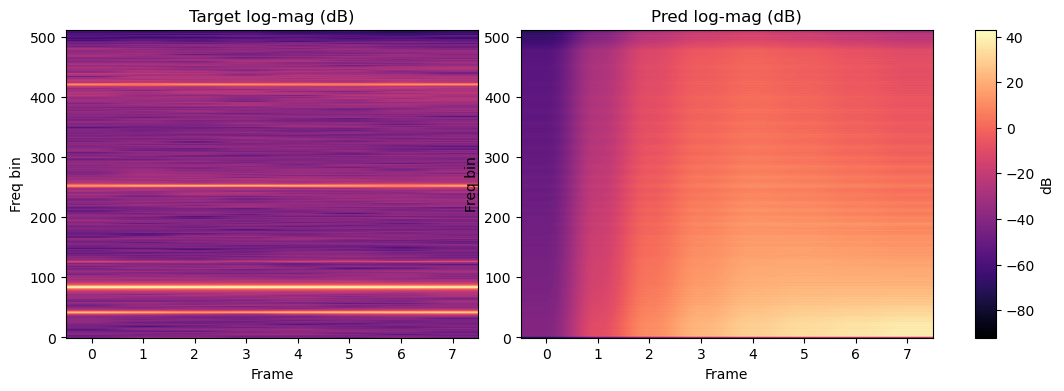

In [7]:
ref_spec = M_ref_denorm[0].numpy().T
pred_spec = M_pred_denorm[0].numpy().T

fig = plt.figure(figsize=(12, 4))
gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 0.05], wspace=0.15)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
cax = fig.add_subplot(gs[0, 2])

im0 = ax0.imshow(ref_spec, origin='lower', aspect='auto', cmap='magma')
ax0.set_title('Target log-mag (dB)')
ax0.set_xlabel('Frame')
ax0.set_ylabel('Freq bin')
ax0.grid(False)

im1 = ax1.imshow(pred_spec, origin='lower', aspect='auto', cmap='magma')
ax1.set_title('Pred log-mag (dB)')
ax1.set_xlabel('Frame')
ax1.set_ylabel('Freq bin')
ax1.grid(False)

fig.colorbar(im0, cax=cax, label='dB')
plt.show()

## 8. Listening to clips
Plays both the reference and the prediction generated by the model.

In [8]:
print('Riferimento:')
Audio(y_ref_np, rate=target_sr)

Riferimento:


In [9]:
print('Predizione autoregressiva:')
Audio(y_pred_np, rate=target_sr)

Predizione autoregressiva:


## 9. Loss analysis
Create a DataFrame with Pandas and view the loss trend.

,run_id,split,epoch,batch_index,global_step,lr,loss_cons,loss_if_nll,loss_if_reg,loss_if_smooth,loss_mag,loss_mag_smooth,loss_mrstft,loss_overlap,loss_stft_cons,loss_time,loss_total,batches
0,run_1759235973,train,1,0.0,0,0.0001,NaN,NaN,inf,0.449322,NaN,0.0,NaN,0.801969,0.0,NaN,NaN,NaN
1,run_1759235973,train,1,1.0,1,0.0001,NaN,NaN,inf,0.350485,NaN,0.0,NaN,0.786725,0.0,NaN,NaN,NaN
2,run_1759235973,train,1,2.0,2,0.0001,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN
3,run_1759235973,train,1,3.0,3,0.0001,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN
4,run_1759235973,train,1,4.0,4,0.0001,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN


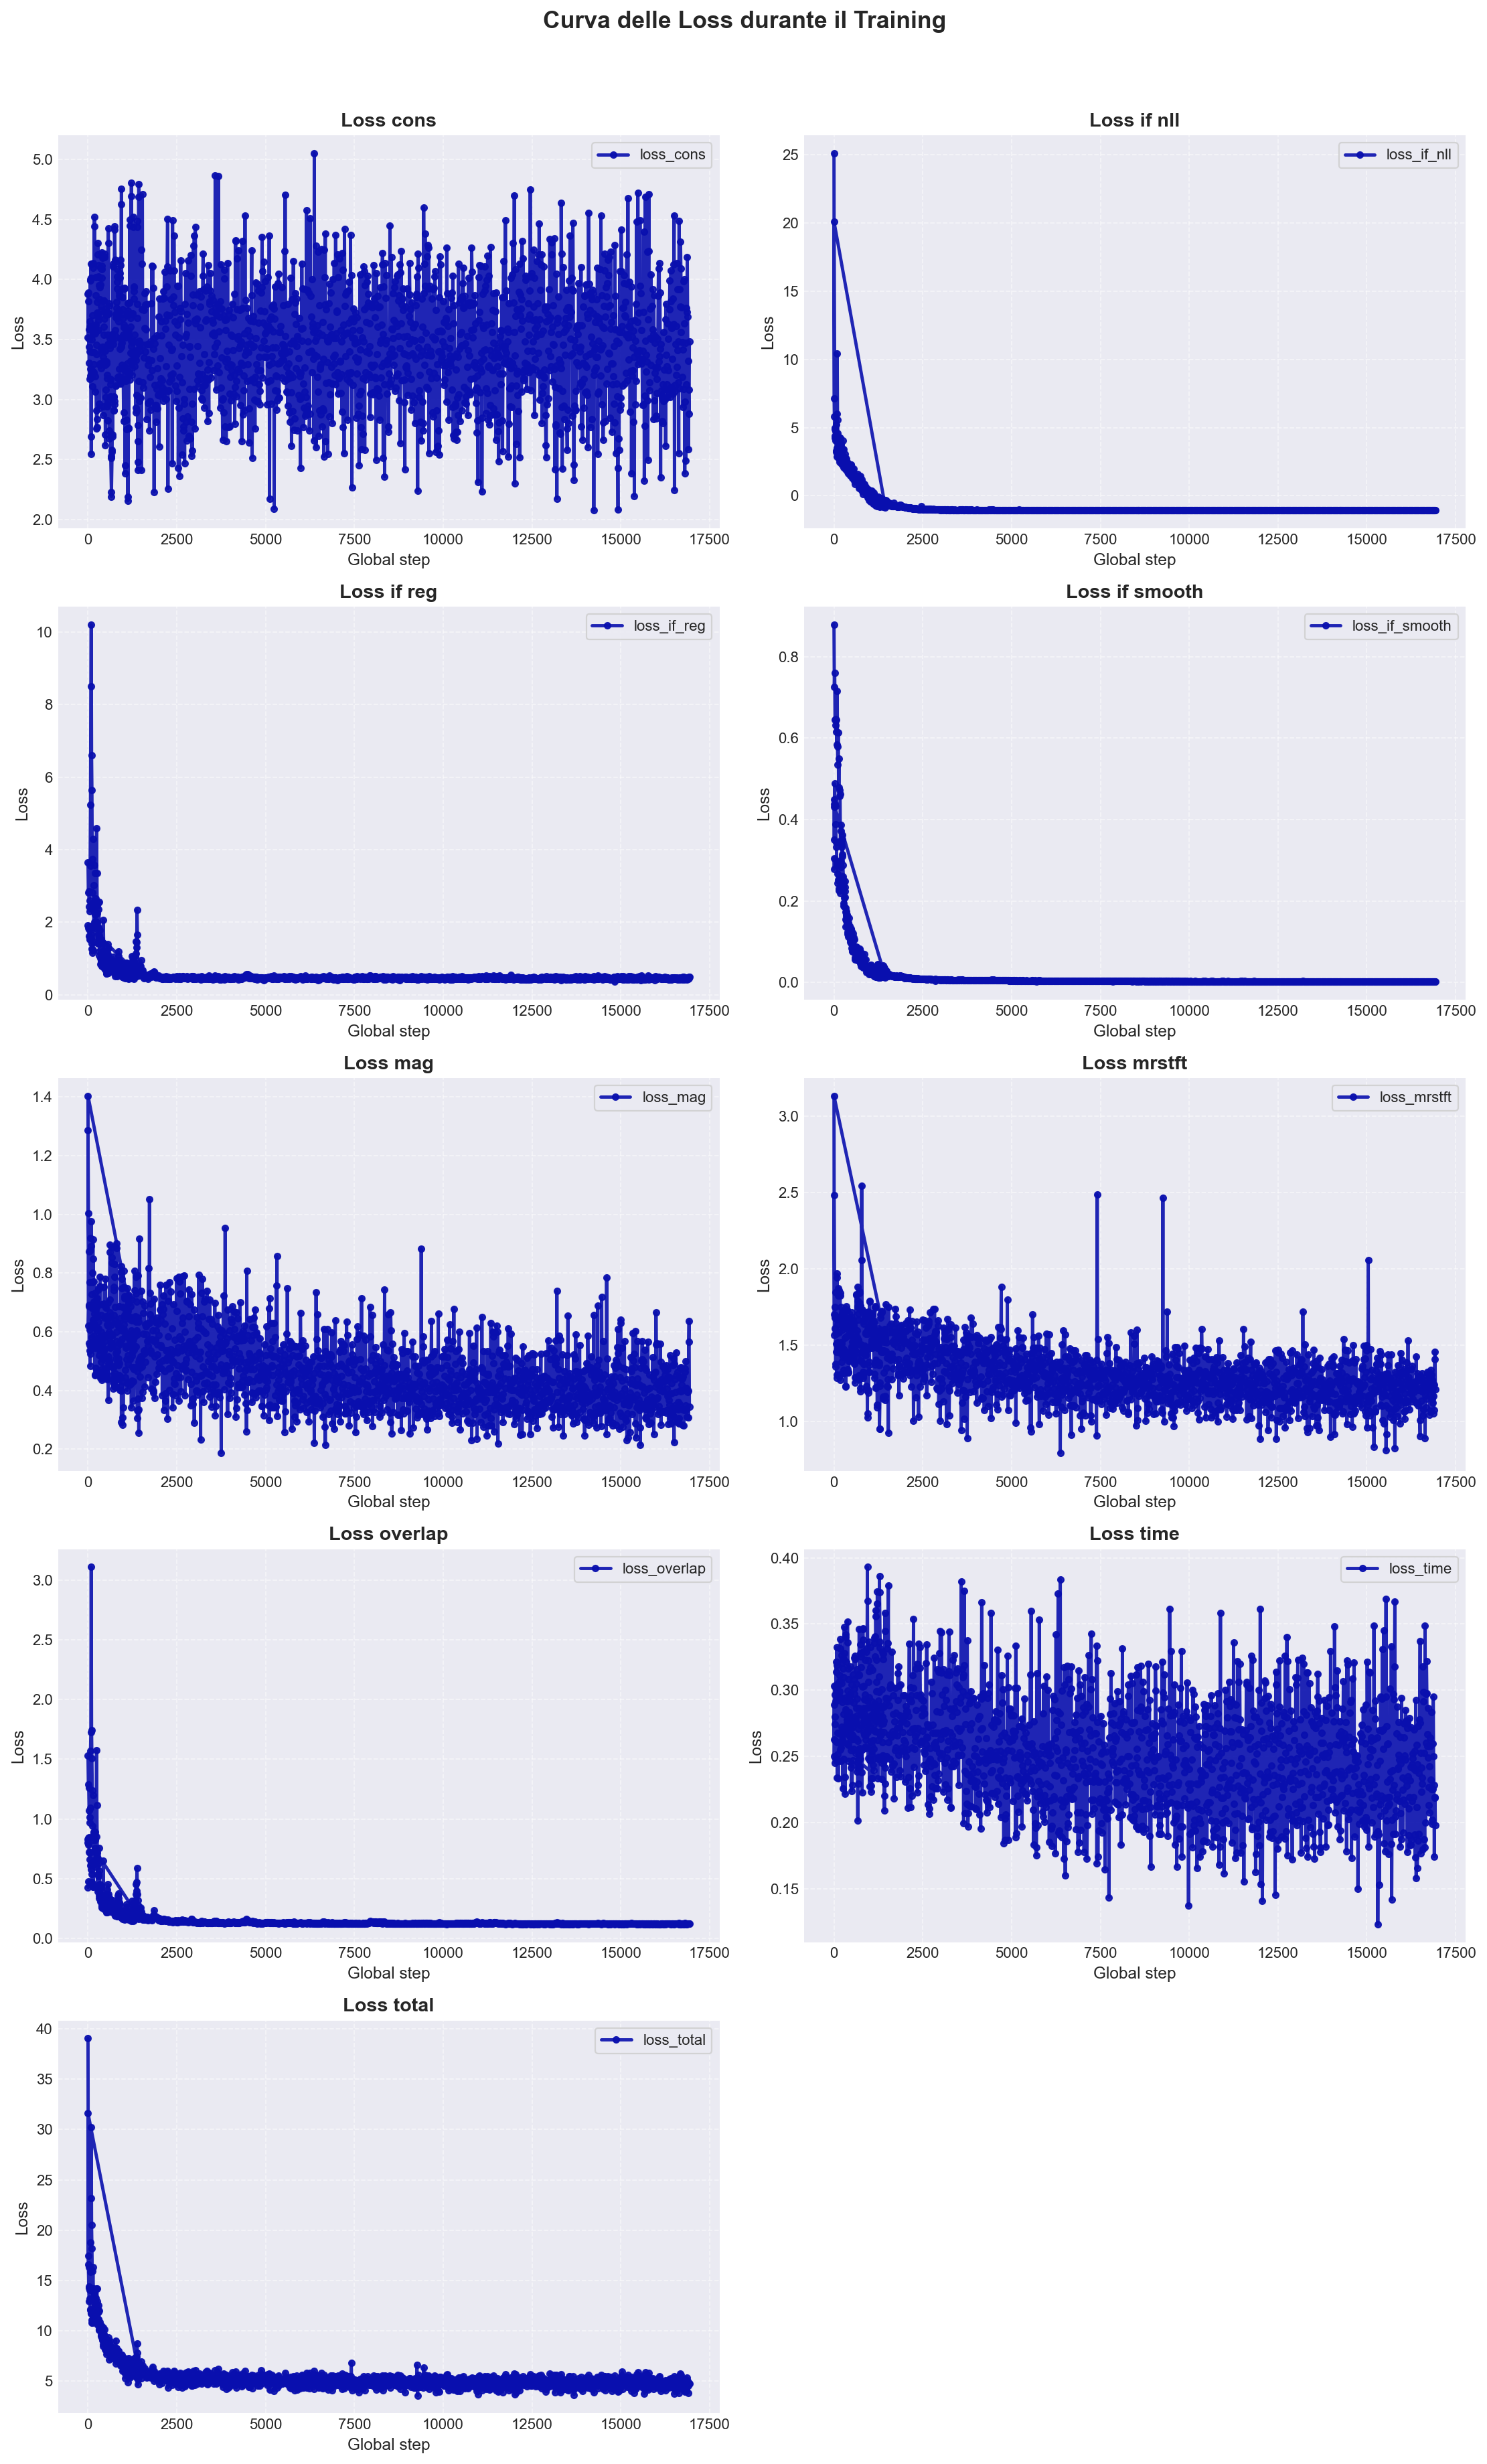

In [10]:
import pandas as pd
import json
import matplotlib.pyplot as plt

file_path = "train_logs/loss_history.jsonl"

data = []
with open(file_path, 'r') as f:
    for line in f:
        data.append(json.loads(line))

if not data:
    raise ValueError('Il file loss_history.jsonl è vuoto: esegui il training prima di generare le curve.')

df = pd.DataFrame(data)
display(df.head())

loss_columns = [col for col in df.columns if col.startswith('loss_')]

valid_cols = []
for col in loss_columns:
    series = df[col].dropna()
    if series.empty:
        continue
    if series.nunique() <= 1: 
        continue
    valid_cols.append(col)

if not valid_cols:
    print('Nessuna colonna di loss valida da plottare.')
else:
    n_cols = min(2, len(valid_cols))
    n_rows = (len(valid_cols) + n_cols - 1) // n_cols

    plt.rcParams['figure.dpi'] = 160        
    plt.rcParams['savefig.dpi'] = 300      
    plt.style.use("seaborn-v0_8-darkgrid")

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4.5 * n_rows), squeeze=False)
    axes = axes.flatten()

    for ax, col in zip(axes, valid_cols):
        y = df[col]
        x = df["global_step"]

        ax.plot(
            x, y,
            linewidth=2.2,
            alpha=0.9,
            marker='o',
            markersize=4,
            label=col, 
            color = "#090FAE"
        )

        ax.set_title(col.replace("_", " ").capitalize(), fontsize=13, fontweight='bold')
        ax.set_xlabel("Global step", fontsize=11)
        ax.set_ylabel("Loss", fontsize=11)

        ax.legend(frameon=True, loc="best")
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.tick_params(axis='both', labelsize=10)

    for ax in axes[len(valid_cols):]:
        fig.delaxes(ax)

    fig.suptitle("Curva delle Loss durante il Training", fontsize=16, fontweight='bold', y=1.02)
    fig.tight_layout()
    plt.show()
